# Working with Unknown Dataset Sizes

This notebook demonstrates the features built into OpenDP to handle unknown or private dataset sizes.

### Load exemplar dataset

In [1]:
# Define parameters up-front
# Each parameter is either a guess, a DP release, or public information
var_names = ["age", "sex", "educ", "race", "income", "married"]  # public information
age_bounds = (0., 120.) # an educated guess
age_prior = 38. # average age for entire US population (public information)
true_count = 1000 # public information

# Load data
import os
import numpy as np
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
age = np.genfromtxt(data_path, delimiter=',', names=var_names)[:]['age'].tolist()

By looking at the private data, we see this dataset has 1000 observations (rows).
Sometimes the number of observations is public information.
For example, a researcher might run a random poll of 1000 respondents and publicly announce the sample size.

However, there are cases where simply the number of observations itself can leak private information.
For example, if a dataset contained all the individuals with a rare disease in a community,
then knowing the size of the dataset would reveal how many people in the community had that condition.
In general, any given dataset may be some well-defined subset of a population.
The given dataset's size is equivalent to a count query on that subset,
so we should protect the dataset size just as we would protect any other query we want to provide privacy guarantees for.

OpenDP assumes the sample size is private information.
If you know the dataset size (or any other parameter) is publicly available,
then you are free to make use of such information while building your measurement.

OpenDP will not assume you truthfully or correctly know the size of the dataset.
Moreover, OpenDP cannot respond with an error message if you get the size incorrect;
doing so would permit an attack whereby an analyst could repeatedly guess different dataset sizes until the error message went away,
thereby leaking the exact dataset size.

If we know the dataset size, we can incorporate it into the analysis as below,
where we provide `size` as an argument to a DP mean measurement on age.

In [2]:
from opendp.trans import *
from opendp.meas import make_base_laplace, make_base_geometric
from opendp.mod import enable_features, binary_search_chain

enable_features("contrib", "floating-point")

dp_mean = (
    # Clamp age values
    make_clamp(bounds=age_bounds) >>
    # Resize with the known `true_count`
    make_bounded_resize(size=true_count, bounds=age_bounds, constant=age_prior) >>
    # Aggregate
    make_sized_bounded_mean(size=true_count, bounds=age_bounds) >>
    # Noise
    make_base_laplace(scale=1.)
)

print("DP mean:", dp_mean(age))

DP mean: 46.38990211234416


### Providing incorrect dataset size values

However, if we provide an incorrect value of `size` we still receive an answer.

`make_mean_measurement` is just a convenience constructor for building a mean measurement from a `size` argument.

In [3]:
def make_mean_measurement(size):
    return make_clamp(age_bounds) >> \
           make_bounded_resize(size=size, bounds=age_bounds, constant=age_prior) >> \
           make_sized_bounded_mean(size=size, bounds=age_bounds) >> \
           make_base_laplace(scale=1.0)

lower_n = make_mean_measurement(size=200)(age)
real_n = make_mean_measurement(size=1000)(age)
higher_n = make_mean_measurement(size=2000)(age)

print("DP mean (n=200):  {0}".format(lower_n))
print("DP mean (n=1000): {0}".format(real_n))
print("DP mean (n=2000): {0}".format(higher_n))

DP mean (n=200):  43.96440121449485
DP mean (n=1000): 44.03920922143149
DP mean (n=2000): 41.276502557678384


### Analysis with no provided dataset size
If we do not believe we have an accurate estimate for `size` we can instead pay some of our privacy budget
to estimate the dataset size.
Then we can use that estimate in the rest of the analysis.
Here is an example:

In [4]:
# First, make the measurement
dp_count = make_count(TIA=float) >> make_base_geometric(scale=1.)

dp_count_release = dp_count(age)
print("DP count: {0}".format(dp_count_release))

dp_mean = make_mean_measurement(dp_count_release)
dp_mean_release = dp_mean(age)
print("DP mean: {0}".format(dp_mean_release))

DP count: 1000
DP mean: 43.7364515135322


In [5]:
def make_count_chain(epsilon):
    counter = make_count(TIA=float)
    return binary_search_chain(
        lambda s: counter >> make_base_geometric(scale=s),
        d_in=1, d_out=epsilon, 
        bounds=(0., 20.))


def make_mean_chain(data_size, epsilon):
    mean_chain = (
        # Clamp age values
        make_clamp(bounds=age_bounds) >>
        # Resize the dataset to length `data_size`.
        #     If there are fewer than `data_size` rows in the data, fill with a constant.
        #     If there are more than `data_size` rows in the data, only keep `data_size` rows
        make_bounded_resize(size=data_size, bounds=age_bounds, constant=age_prior) >>
        # Compute the mean
        make_sized_bounded_mean(size=data_size, bounds=age_bounds)
    )
    return binary_search_chain(
        lambda s: mean_chain >> make_base_laplace(scale=s),
        d_in=1, d_out=epsilon, 
        bounds=(0., 10.))

def make_sum_chain(epsilon):
    bounded_age_sum = (
        # Clamp income values
        make_clamp(bounds=age_bounds) >>
        # These bounds must be identical to the clamp bounds, otherwise chaining will fail
        make_bounded_sum(bounds=age_bounds)
    )
    return binary_search_chain(
        lambda s: bounded_age_sum >> make_base_laplace(scale=s),
        d_in=1, d_out=epsilon,
        bounds=(0., 1000.))

In [6]:
import random

n_simulations = 1_000

history_count = []
history_mean = []

print("Status:")
for i in range(n_simulations):
    if i % 100 == 0:
        print(f"{i / n_simulations:.0%} ", end="")
        
    # See https://github.com/opendp/opendp/issues/357
    random.shuffle(age)
    
    count_chain = make_count_chain(epsilon=0.05)
    history_count.append(count_chain(age))
    
    mean_chain = make_mean_chain(data_size=history_count[-1], epsilon=1.)
    history_mean.append(mean_chain(age))

print("100%")

Status:
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


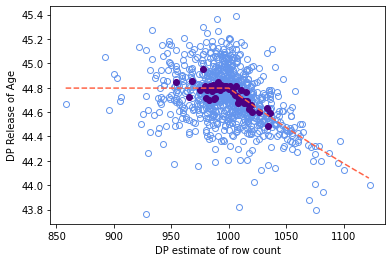

In [7]:
import matplotlib.pyplot as plt
import statistics

true_mean_age = statistics.mean(age)

# The light blue circles are DP means
plt.plot(history_count, history_mean, 'o', fillstyle='none', color = 'cornflowerblue')

def compute_expected_mean(count):
    count = max(count, true_count)
    return ((true_mean_age * true_count) + (count - true_count) * age_prior) / count

expected_count = list(range(min(history_count), max(history_count)))
expected_mean = list(map(compute_expected_mean, expected_count))

# The dark blue dots are the average DP mean per dataset size
for count in expected_count:
    sims = [m for c, m in zip(history_count, history_mean) if c == count]
    if len(sims) > 6:
        plt.plot(count, statistics.mean(sims), 'o', color = 'indigo')

# The red line is the expected value by dp release of dataset size
plt.plot(expected_count, expected_mean, linestyle='--', color = 'tomato')
plt.ylabel('DP Release of Age')
plt.xlabel('DP estimate of row count')
plt.show()

Our privacy usage has increased because we apportioned some epsilon for both the release count of the dataset,
and the mean of the dataset.

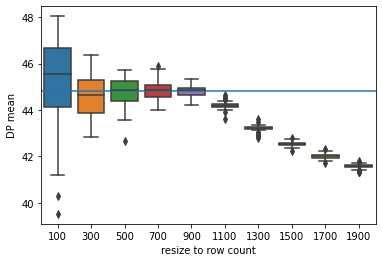

In [8]:
import pandas as pd
import seaborn as sns

releases = []
# X axis ticks
n_range = range(100, 2001, 200)
# Number of samples per boxplot
n_simulations = 50

for n in n_range:
    mean_chain = make_mean_chain(n, epsilon=1.)
    for index in range(n_simulations):
        # See https://github.com/opendp/opendp/issues/357
        random.shuffle(age)
        
        # get mean of age at the given n
        releases.append((n, mean_chain(age)))

# get released values
df = pd.DataFrame.from_records(releases, columns=['resize to row count', 'DP mean'])

# The boxplots show the distribution of releases per n
plot = sns.boxplot(x = 'resize to row count', y = 'DP mean', data = df)
# The blue line is the true mean
plot.axhline(true_mean_age)
plt.show()

### OpenDP `resize` vs. other approaches
The standard formula for the mean of a variable is:
$\bar{x} = \frac{\sum{x}}{n}$

The conventional, and simpler, approach in the differential privacy literature, is to: 

1. compute a DP sum of the variable for the numerator
2. compute a DP count of the dataset rows for the denominator
3. take their ratio

This is sometimes called a 'plug-in' approach, as we are plugging-in differentially private answers for each of the
terms in the original formula, without any additional modifications, and using the resulting answer as our
estimate while ignoring the noise processes of differential privacy. While this 'plug-in' approach does result in a
differentially private value, the utility here is generally lower than the solution in OpenDP.  Because the number of
terms summed in the numerator does not agree with the value in the denominator, the variance is increased and the
resulting distribution becomes both biased and asymmetrical, which is visually noticeable in smaller samples.

In [9]:
n_simulations = 1_000
history_plugin = []
history_resize = []

# sized estimators are more robust to noisy counts, so epsilon is small
# the less epsilon provided to this count, the more the result will be biased towards the prior
resize_count = make_count_chain(epsilon=0.2)

# plugin estimators want a much more accurate count
plugin_count = make_count_chain(epsilon=0.5)
plugin_sum = make_sum_chain(epsilon=0.5)

print("Status:")
for i in range(n_simulations):
    if i % 100 == 0:
        print(f"{i / n_simulations:.0%} ", end="")
    
    # See https://github.com/opendp/opendp/issues/357
    random.shuffle(age)

    history_plugin.append(plugin_sum(age) / plugin_count(age))

    resize_mean = make_mean_chain(resize_count(age), epsilon=.8)
    history_resize.append(resize_mean(age))
    
print('100%')

Status:
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


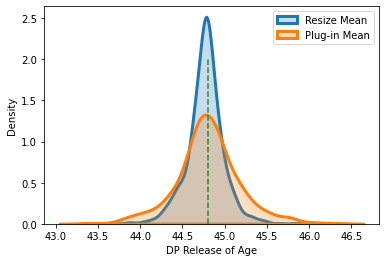

In [10]:
fig, ax = plt.subplots()
sns.kdeplot(history_resize, fill=True, linewidth=3,
                 label = 'Resize Mean')
sns.kdeplot(history_plugin, fill=True, linewidth=3,
                 label = 'Plug-in Mean')

ax.plot([true_mean_age,true_mean_age], [0,2], linestyle='--', color = 'forestgreen')
plt.xlabel('DP Release of Age')
leg = ax.legend()

We have noticed that for the same privacy loss,
the distribution of answers from OpenDP's resizing approach to the mean is tighter around the true dataset value (thus lower in error) than the conventional plug-in approach.

*Note, in these simulations, we've shown equal division of the epsilon for all constituent releases,
but higher utility (lower error) can be generally gained by moving more of the epsilon into the sum,
and using less in the count of the dataset rows, as in earlier examples.*